In [1]:
# imports
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# no max rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# install
!pip install fastparquet

In [3]:
# load crash data
train = pd.read_parquet("/Users/elizabethpysher/spoke/pipeline_data/2019_thru_2021/train.parquet")
dev = pd.read_parquet("/Users/elizabethpysher/spoke/pipeline_data/2019_thru_2021/eval.parquet")
test = pd.read_parquet("/Users/elizabethpysher/spoke/pipeline_data/2019_thru_2021/test.parquet")

# check shapes
print("train shape: ", train.shape)
print("dev shape: ", dev.shape)
print("test shape: ", test.shape)

train shape:  (13676984, 41)
dev shape:  (4558995, 41)
test shape:  (4558995, 41)


In [4]:
# examine head
train.head()

,EVENT_DATE,EVENT_TIME,IS_CRASH,AWND,PGTM,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10,WT11,WT13,WT14,WT15,WT16,WT18,WT19,WT22,residential,service,secondary,primary,cycleway,unclassified,trunk,pedestrian,tertiary,path,secondary_link,living_street,primary_link
2081026,340,31235.682,False,10.316250,2025.50,0.000127,0.0,0.417391,46.214286,31.857143,33.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13892716,158,61315.748,False,8.181429,1558.00,0.404432,0.0,0.000000,84.214286,66.928571,70.000000,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11934664,333,83997.996,False,11.715000,521.50,0.000260,0.0,0.000000,45.500000,24.142857,30.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
8636938,172,62606.920,False,10.065000,1303.50,0.647500,0.0,0.000000,79.076923,64.928571,68.500000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4407752,221,57980.122,False,6.598750,1176.75,0.120588,0.0,0.000000,85.428571,66.785714,67.833333,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# look for outliers
train.describe()

,EVENT_DATE,EVENT_TIME,AWND,PGTM,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10,WT11,WT13,WT14,WT15,WT16,WT18,WT19,WT22,residential,service,secondary,primary,cycleway,unclassified,trunk,pedestrian,tertiary,path,secondary_link,living_street,primary_link
count,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,13676984.0,1.367698e+07,13676984.0,13676984.0,13676984.0,13676984.0,13676984.0,13676984.0,13676984.0,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07
mean,1.947017e+02,5.262883e+04,7.768428e+00,1.301508e+03,1.296435e-01,1.865502e-02,5.285212e-02,6.753832e+01,5.054260e+01,5.295503e+01,5.657372e-01,9.687202e-02,2.115079e-01,3.120015e-02,8.124379e-03,1.183075e-02,2.758367e-01,2.252178e-03,0.0,2.452690e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.791704e+00,1.865302e-01,1.135846e+00,8.408221e-01,3.010175e-01,1.034314e-01,7.996646e-04,1.076661e-01,7.107437e-02,4.451566e-03,1.398993e-02,1.155767e-02,8.765090e-03
std,9.838313e+01,1.701540e+04,3.043891e+00,3.957676e+02,2.796745e-01,1.970000e-01,3.659107e-01,1.690296e+01,1.590123e+01,1.585062e+01,4.956598e-01,2.957834e-01,4.083777e-01,1.738583e-01,8.976845e-02,1.081239e-01,4.469349e-01,4.740365e-02,0.0,1.546782e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.420882e+00,6.267650e-01,1.463021e+00,1.395609e+00,8.266592e-01,5.045174e-01,2.826703e-02,5.533865e-01,3.952031e-01,9.425135e-02,1.314987e-01,1.239350e-01,1.118547e-01
min,1.000000e+00,0.000000e+00,1.957500e+00,4.075000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.961538e+01,1.615385e+00,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.130000e+02,3.943422e+04,5.566250e+00,1.111000e+03,3.571429e-04,0.000000e+00,0.000000e+00,5.321429e+01,3.692857e+01,3.980000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.110000e+02,5.497257e+04,7.101250e+00,1.353500e+03,9.764706e-03,0.000000e+00,0.000000e+00,7.023077e+01,5.242857e+01,5.580000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.720000e+02,6.571478e+04,9.228750e+00,1.510000e+03,1.101282e-01,0.000000e+00,0.000000e+00,8.228571e+01,6.507692e+01,6.680000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.660000e+02,8.639999e+04,2.542667e+01,2.335500e+03,5.207917e+00,6.385965e+00,1.298788e+01,9.771429e+01,7.921429e+01,8.180000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.500000e+01,1.000000e+01,7.000000e+00,6.000000e+00,6.000000e+00,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00


In [6]:
# examine data types
train.dtypes

EVENT_DATE          int64
EVENT_TIME        float64
IS_CRASH             bool
AWND              float64
PGTM              float64
PRCP              float64
SNOW              float64
SNWD              float64
TMAX              float64
TMIN              float64
TOBS              float64
WT01              float64
WT02              float64
WT03              float64
WT04              float64
WT05              float64
WT06              float64
WT08              float64
WT09              float64
WT10              float64
WT11              float64
WT13              float64
WT14              float64
WT15              float64
WT16              float64
WT18              float64
WT19              float64
WT22              float64
residential       float64
service           float64
secondary         float64
primary           float64
cycleway          float64
unclassified      float64
trunk             float64
pedestrian        float64
tertiary          float64
path              float64
secondary_li

In [7]:
# convert boolean IS_CRASH to int for LogReg
train['IS_CRASH'] = train['IS_CRASH'].astype(int)
dev['IS_CRASH'] = dev['IS_CRASH'].astype(int)

In [8]:
# confirm IS_CRASH converted
train.dtypes

EVENT_DATE          int64
EVENT_TIME        float64
IS_CRASH            int64
AWND              float64
PGTM              float64
PRCP              float64
SNOW              float64
SNWD              float64
TMAX              float64
TMIN              float64
TOBS              float64
WT01              float64
WT02              float64
WT03              float64
WT04              float64
WT05              float64
WT06              float64
WT08              float64
WT09              float64
WT10              float64
WT11              float64
WT13              float64
WT14              float64
WT15              float64
WT16              float64
WT18              float64
WT19              float64
WT22              float64
residential       float64
service           float64
secondary         float64
primary           float64
cycleway          float64
unclassified      float64
trunk             float64
pedestrian        float64
tertiary          float64
path              float64
secondary_li

In [9]:
# MDSF Multi-day snowfall total
# DASF Days included in MDSF
# MDPR Multi-day precipitation total
# DAPR Days included in MDPR
# PSUN Daily percent of possible sunshine
# TSUN Daily total sunshine
# TAVG: Average temperature (degrees F)
# WESD: Water equivalent of snow on the ground (inches)
# WESF: Water equivalent of snowfall (inches)
# WSF2: Fastest 2-minute wind speed (mph)
# WSF5: Fastest 5-second wind speed (mph)
# WDF2: Direction of fastest 2-minute wind (degrees)
# WDF5: Direction of fastest 5-minute wind (degrees)

# The following columns are continuous:

# AWND: Average wind speed (mph)
# PGTM: Peak gust time (hours and minutes, i.e., HHMM)
# PRCP: Amount of precipitation (inches)
# SNOW: Amount of snowfall (inches)
# SNWD: Snow depth on ground (inches)
# TMAX: Maximum temperature (degrees F)
# TMIN: Minimum temperature (degrees F)
# TOBS: Temperature at the time of observation (degrees F)
# The following columns contain a 1 if the specified weather condition was observed. 0 otherwise.

# WT01: Fog, ice fog, or freezing fog (may include heavy fog)
# WT02: Heavy fog or heaving freezing fog (not always distinguished from fog)
# WT03: Thunder
# WT04: Ice pellets, sleet, snow pellets, or small hail
# WT05: Hail (may include small hail)
# WT06: Glaze or rime
# WT08: Smoke or haze
# WT09: Blowing or drifting snow
# WT11: High or damaging winds
# WT13: Mist
# WT14: Drizzle
# WT15: Freezing Drizzle
# WT16: Rain (may include freezing rain, drizzle, and freezing drizzle)
# WT18: Snow, snow pellets, snow grains, or ice crystals
# WT19: Unknown source of precipitation
# WT22: Ice fog or freezing fog
   
# create lists of duplicate / similar / empty columns
cols = train.columns
cols_no_values = []
cols_remove = []

for col in cols:
    if sum(train[col]) == 0:
        cols_no_values.append(col)
        
cols_duplicate = ['PGTM', 'SNWD', 'TMAX', 'TMIN', 'TOBS', 'WT01', 'WT02', 'WT05', 'WT06','WT11']

In [10]:
# create list of columns to drop
print(cols_no_values)
print(cols_duplicate)
cols_remove.extend(cols_no_values)
cols_remove.extend(cols_duplicate)
print(cols_remove)
len(cols_remove)

['WT10', 'WT13', 'WT14', 'WT15', 'WT16', 'WT18', 'WT19', 'WT22']
['PGTM', 'SNWD', 'TMAX', 'TMIN', 'TOBS', 'WT01', 'WT02', 'WT05', 'WT06', 'WT11']
['WT10', 'WT13', 'WT14', 'WT15', 'WT16', 'WT18', 'WT19', 'WT22', 'PGTM', 'SNWD', 'TMAX', 'TMIN', 'TOBS', 'WT01', 'WT02', 'WT05', 'WT06', 'WT11']


18

<AxesSubplot:>

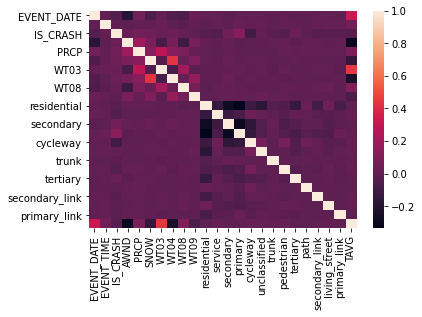

In [11]:
# create smaller sample for correlation plot
train_0 = train.loc[train['IS_CRASH'] == 0]
train_1 = train.loc[train['IS_CRASH'] == 1]
train_0_sample = train_0.sample(n=10000)
correlation = pd.concat([train_1,train_0_sample])

# create average temperature singular value instead of min and max
correlation['TAVG'] = correlation[['TMAX', 'TMIN']].mean(axis=1)

# drop unwanted columns
correlation = correlation.drop(cols_remove, axis=1)

# plot correlations
sns.heatmap(correlation.corr())

In [12]:
# look at fraction of 1s v 0s in train, dev, test
print("fraction of train positives: ", train['IS_CRASH'].sum() / train.shape[0])
print("fraction of dev positives: ", dev['IS_CRASH'].sum() / dev.shape[0])
print("fraction of test positives: ", test['IS_CRASH'].sum() / test.shape[0])

fraction of train positives:  0.0001438182570075391
fraction of dev positives:  0.00015507803803250497
fraction of test positives:  0.00014674286767149338


In [13]:
# create average temperature instead of min and max
train['TAVG'] = train[['TMAX', 'TMIN']].mean(axis=1)
dev['TAVG'] = dev[['TMAX', 'TMIN']].mean(axis=1)
test['TAVG'] = test[['TMAX', 'TMIN']].mean(axis=1)

# drop columns and create x and y sets
train_x = train.drop(cols_remove, axis = 1)
train_x = train_x.drop('IS_CRASH', axis = 1)
train_y = train['IS_CRASH']

dev_x = dev.drop(cols_remove, axis = 1)
dev_x = dev_x.drop('IS_CRASH', axis = 1)
dev_y = dev['IS_CRASH']

test_x = test.drop(cols_remove, axis = 1)
test_x = test_x.drop('IS_CRASH', axis = 1)
test_y = test['IS_CRASH']

In [14]:
# check shapes
print( "train_x shape: ", train_x.shape)
print( "train_y shape: ", train_y.shape)

print( "dev_x shape: ", dev_x.shape)
print( "dev_y shape: ", dev_y.shape)

print( "test_x shape: ", test_x.shape)
print( "test_y shape: ", test_y.shape)

train_x shape:  (13676984, 23)
train_y shape:  (13676984,)
dev_x shape:  (4558995, 23)
dev_y shape:  (4558995,)
test_x shape:  (4558995, 23)
test_y shape:  (4558995,)


In [15]:
# scale train dev and test
scaler = StandardScaler()

train_x = scaler.fit_transform(train_x)
dev_x = scaler.fit_transform(dev_x)
test_x = scaler.fit_transform(test_x)

In [16]:
# train Logistic Regression model with default weights
lr1 = LogisticRegression(penalty='none',max_iter=1000)
lr1.fit(train_x, train_y)

LogisticRegression(max_iter=1000, penalty='none')

In [17]:
# compute AUC score of fitted model with default weights on train set
print("No Weights train ROC AUC score: ", roc_auc_score(train_y, lr1.predict_proba(train_x)[:,1]))

# compute AUC score of fitted model with default weights on dev set
print("No Weights dev ROC AUC score: ", roc_auc_score(dev_y, lr1.predict_proba(dev_x)[:,1]))

No Weights train ROC AUC score:  0.6473718010996552
No Weights dev ROC AUC score:  0.6572071934389262


In [18]:
# look at predictions
NoWeightpredictions = lr1.predict_proba(train_x)[:,1]

# look at how many CRASH predictions
NoWeightbinary_predictions = NoWeightpredictions > 0.5
print('No Weights fraction crash predictions', NoWeightbinary_predictions.mean()) 

# look at true Train crashes
NoWeightground_truth = train_y
print("No Weights fraction true crashes: ", sum(NoWeightground_truth)/(train.shape[0]))

No Weights fraction crash predictions 0.0
No Weights fraction true crashes:  0.0001438182570075391


No Weights fnr 1.0


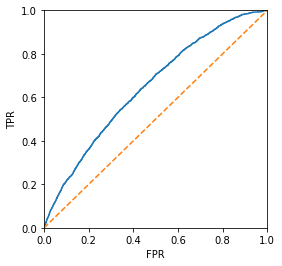

In [19]:
# False positive rate (FPR): nothing is classified as positive
# False negative rate (FNR): everything is classified as negative
print('No Weights fnr', (NoWeightbinary_predictions == 0)[NoWeightground_truth == 1].mean())

from sklearn import metrics 
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_true=NoWeightground_truth, y_score=NoWeightpredictions)
metrics.roc_auc_score(y_true=NoWeightground_truth, y_score=NoWeightpredictions)
plt.figure(figsize=[4, 4])
plt.plot(fpr1, tpr1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle='--')

In [20]:
# train Log Reg model with class weights .0001 and .9999 due to imbalanced data
lr2 = LogisticRegression(class_weight={0:0.0001,1:0.9999},penalty='none',max_iter=1000)
lr2.fit(train_x, train_y)

LogisticRegression(class_weight={0: 0.0001, 1: 0.9999}, max_iter=1000,
                   penalty='none')

In [21]:
# compute AUC score of fitted model on train set
print("Class Weights train ROC AUC score: ", roc_auc_score(train_y, lr2.predict_proba(train_x)[:,1]))

# compute AUC score of fitted model on dev set
print("Class Weights dev ROC AUC score: ", roc_auc_score(dev_y, lr2.predict_proba(dev_x)[:,1]))

Class Weights train ROC AUC score:  0.6467366429365475
Class Weights dev ROC AUC score:  0.6563171799590397


In [22]:
# look at predictions
predictions = lr2.predict_proba(train_x)[:,1]

# look at how many CRASH predictions
binary_predictions = predictions > 0.5
print('fraction crash predictions', binary_predictions.mean()) 

# look at how many true crashes
ground_truth = train['IS_CRASH'].values
print("fraction true crashes: ", sum(ground_truth)/(train.shape[0]))

fraction crash predictions 0.731982065636693
fraction true crashes:  0.0001438182570075391


fnr 0.10930350788002034


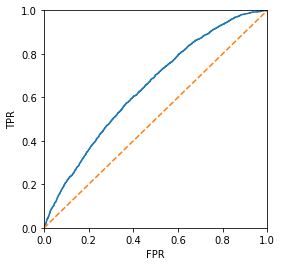

In [23]:
# False positive rate (FPR): nothing is classified as positive
# False negative rate (FNR): everything is classified as negative
print('fnr', (binary_predictions == 0)[ground_truth == 1].mean())

from sklearn import metrics 
fpr, tpr, thresholds = metrics.roc_curve(y_true=ground_truth, y_score=predictions)
metrics.roc_auc_score(y_true=ground_truth, y_score=predictions)
plt.figure(figsize=[4, 4])
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle='--')

In [34]:
# train Log Reg model with class weights .001 and .999 due to imbalanced data
lr = LogisticRegression(class_weight={0:0.001,1:0.999},penalty='none',max_iter=1000)
lr.fit(train_x, train_y)

LogisticRegression(class_weight={0: 0.001, 1: 0.999}, max_iter=1000,
                   penalty='none')

In [35]:
# compute AUC score of fitted model on train set
print("Class Weights train ROC AUC score: ", roc_auc_score(train_y, lr.predict_proba(train_x)[:,1]))

# compute AUC score of fitted model on dev set
print("Class Weights dev ROC AUC score: ", roc_auc_score(dev_y, lr.predict_proba(dev_x)[:,1]))

# compute AUC score of fitted model on test set
print("Class Weights test ROC AUC score: ", roc_auc_score(test_y, lr.predict_proba(test_x)[:,1]))

Class Weights train ROC AUC score:  0.6475217727055628
Class Weights dev ROC AUC score:  0.6573528075512464
Class Weights test ROC AUC score:  0.6334746689490086


In [29]:
# look at predictions
predictions = lr.predict_proba(train_x)[:,1]

# look at how many CRASH predictions
binary_predictions = predictions > 0.5
print('fraction crash predictions', binary_predictions.mean()) 

# look at how many true crashes
ground_truth = train['IS_CRASH'].values
print("fraction true crashes: ", sum(ground_truth)/(train.shape[0]))

fraction crash predictions 9.205245834900443e-05
fraction true crashes:  0.0001438182570075391


fnr 0.9989832231825114


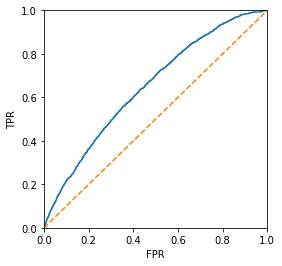

In [30]:
# False positive rate (FPR): nothing is classified as positive
# False negative rate (FNR): everything is classified as negative
print('fnr', (binary_predictions == 0)[ground_truth == 1].mean())

from sklearn import metrics 
fpr, tpr, thresholds = metrics.roc_curve(y_true=ground_truth, y_score=predictions)
metrics.roc_auc_score(y_true=ground_truth, y_score=predictions)
plt.figure(figsize=[4, 4])
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle='--')

<AxesSubplot:>

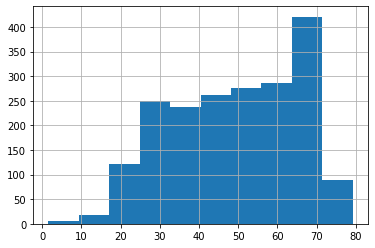

In [24]:
# look at distribution of minimum temperature of crashes
train.query('IS_CRASH==1').TMIN.hist()

<AxesSubplot:>

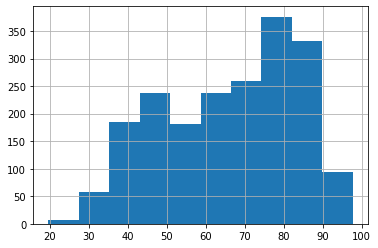

In [25]:
# look at distribution of maximum temperature of crashes
train.query('IS_CRASH==1').TMAX.hist()

<AxesSubplot:>

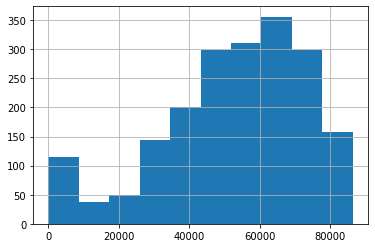

In [26]:
# look at distribution of time of crashes
train.query('IS_CRASH==1').EVENT_TIME.hist()